<a href="https://colab.research.google.com/github/Khairazzz/NLP-Transformers/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
np.set_printoptions(precision=4, suppress=True)

In [2]:
def softmax(x, axis=-1):
    x_max = np.max(x, axis=axis, keepdims=True)
    e = np.exp(x - x_max)
    return e / np.sum(e, axis=axis, keepdims=True)

def glorot_init(shape):
    if len(shape) == 2:
        fan_in, fan_out = shape
    else:
        fan_in = shape[0]
        fan_out = shape[-1]
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=shape).astype(np.float32)

In [3]:
def sinusoidal_pos_enc(max_len, d_model):
    pos = np.arange(max_len)[:, None]
    i = np.arange(d_model)[None, :]
    angle_rates = 1 / (10000 ** (2 * (i//2) / d_model))
    angle = pos * angle_rates
    pe = np.zeros((max_len, d_model), dtype=np.float32)
    pe[:, 0::2] = np.sin(angle[:, 0::2])
    pe[:, 1::2] = np.cos(angle[:, 1::2])
    return pe

class RotaryPositionalEmbedding:
    def __init__(self, max_seq_len, head_dim):
        # Precompute theta values
        theta = 1.0 / (10000 ** (np.arange(0, head_dim, 2) / head_dim))
        t = np.arange(max_seq_len)
        freqs = np.outer(t, theta) # Shape: (max_seq_len, head_dim/2)

        # Precompute cosine and sine matrices for all positions
        self.cos_m = np.cos(freqs)
        self.sin_m = np.sin(freqs)

    def apply(self, x, seq_len):
        # x shape: (batch, heads, seq, head_dim)
        cos = self.cos_m[:seq_len, :][None, None, :, :] # (1, 1, seq, head_dim/2)
        sin = self.sin_m[:seq_len, :][None, None, :, :] # (1, 1, seq, head_dim/2)

        # Split x into two halves for rotation
        x1, x2 = x[..., 0::2], x[..., 1::2] # (b, h, seq, head_dim/2) each

        # Apply rotation formula: x_rot = x * cos + rotate_half(x) * sin
        x_rotated = np.zeros_like(x)
        x_rotated[..., 0::2] = x1 * cos - x2 * sin
        x_rotated[..., 1::2] = x2 * cos + x1 * sin

        return x_rotated

In [4]:
class LayerNorm:
    def __init__(self, d_model, eps=1e-5):
        self.eps = eps
        self.gamma = np.ones((d_model,), dtype=np.float32)
        self.beta = np.zeros((d_model,), dtype=np.float32)
    def __call__(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        var = np.var(x, axis=-1, keepdims=True)
        x_norm = (x - mean) / np.sqrt(var + self.eps)
        return x_norm * self.gamma + self.beta

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.transpose(0,1,3,2)) / np.sqrt(d_k)
    if mask is not None:
        scores = np.where(mask == 0, -1e9, scores)
    weights = softmax(scores, axis=-1)
    out = np.matmul(weights, V)
    return out, weights

In [5]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads, rope=None):
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.rope = rope

        self.W_q = glorot_init((d_model, d_model))
        self.W_k = glorot_init((d_model, d_model))
        self.W_v = glorot_init((d_model, d_model))
        self.W_o = glorot_init((d_model, d_model))

    def split_heads(self, x):
        b, seq, _ = x.shape
        x = x.reshape(b, seq, self.num_heads, self.head_dim)
        return x.transpose(0,2,1,3)

    def combine_heads(self, x):
        b, h, seq, hd = x.shape
        x = x.transpose(0,2,1,3).reshape(b, seq, h*hd)
        return x

    def __call__(self, x, mask=None):
        Q = x @ self.W_q
        K = x @ self.W_k
        V = x @ self.W_v

        Qh = self.split_heads(Q)
        Kh = self.split_heads(K)
        Vh = self.split_heads(V)

        if self.rope is not None:
            seq_len = Qh.shape[2]
            Qh = self.rope.apply(Qh, seq_len)
            Kh = self.rope.apply(Kh, seq_len)

        attn_out, attn_weights = scaled_dot_product_attention(Qh, Kh, Vh, mask=mask)
        concat = self.combine_heads(attn_out)
        out = concat @ self.W_o
        return out, attn_weights

class FeedForward:
    def __init__(self, d_model, d_ff):
        self.W1 = glorot_init((d_model, d_ff))
        self.b1 = np.zeros((d_ff,), dtype=np.float32)
        self.W2 = glorot_init((d_ff, d_model))
        self.b2 = np.zeros((d_model,), dtype=np.float32)
    def __call__(self, x):
        h = np.matmul(x, self.W1) + self.b1
        h = np.maximum(0, h)
        out = np.matmul(h, self.W2) + self.b2
        return out

In [6]:
class DecoderBlock:
    def __init__(self, d_model, num_heads, d_ff, rope=None):
        self.ln1 = LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, num_heads, rope=rope) #
        self.ln2 = LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff)
    def __call__(self, x, mask=None):
        x_norm = self.ln1(x)
        mha_out, attn_weights = self.mha(x_norm, mask=mask)
        x = x + mha_out
        x_norm = self.ln2(x)
        ff_out = self.ff(x_norm)
        x = x + ff_out
        return x, attn_weights

class TransformerDecoder:
    def __init__(self, vocab_size, max_seq_len, d_model=32, num_heads=4, num_layers=2,
                d_ff=128, pos_encoding_method='sinusoidal', use_weight_tying=False):
        self.pos_encoding_method = pos_encoding_method
        head_dim = d_model // num_heads

        # Embedding
        self.W_embed = glorot_init((vocab_size, d_model))

        # Positional Encoding Setup
        if pos_encoding_method == 'rope':
            self.rope = RotaryPositionalEmbedding(max_seq_len, head_dim)
        elif pos_encoding_method == 'sinusoidal':
            self.pos_enc = sinusoidal_pos_enc(max_seq_len, d_model)
            self.rope = None
        else:
            raise ValueError("Unsupported pos_encoding_method")

        # Stack of decoder blocks
        self.blocks = [DecoderBlock(d_model, num_heads, d_ff, rope=self.rope) for _ in range(num_layers)]

        if use_weight_tying:
            self.W_out = self.W_embed.T
        else:
            self.W_out = glorot_init((d_model, vocab_size))

    def create_causal_mask(self, seq_len):
        m = np.tril(np.ones((seq_len, seq_len), dtype=np.float32))
        return m.reshape(1, 1, seq_len, seq_len)

    def forward(self, tokens):
        b, seq = tokens.shape

        x = self.W_embed[tokens]

        if self.pos_encoding_method == 'sinusoidal':
            x = x + self.pos_enc[:seq]

        mask = self.create_causal_mask(seq)
        attn_maps = []
        for block in self.blocks:
            x, attn_weights = block(x, mask=mask)
            attn_maps.append(attn_weights)

        logits = np.matmul(x, self.W_out)
        last_logits = logits[:, -1, :]
        probs = softmax(last_logits, axis=-1)
        return logits, probs, attn_maps

In [7]:
def visualize_attention(attention_map, tokens, layer, head):
    attn_data = attention_map[0, head]
    token_labels = [str(t) for t in tokens[0]]

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_data, xticklabels=token_labels, yticklabels=token_labels,
                annot=True, cmap='viridis', fmt=".2f")
    plt.title(f"Attention Heatmap (Layer {layer}, Head {head})")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()

=== PENGUJIAN DENGAN FITUR BONUS ===
Menggunakan RoPE: True
Menggunakan Weight Tying: True

=== OUTPUTS ===
logits shape: (2, 6, 50)
probs shape (next token): (2, 50)
sum probs each batch (should ~1): [1. 1.]

Attention weights for layer 0, head 0 (batch 0):
 [[1.     0.     0.     0.     0.     0.    ]
 [0.6502 0.3498 0.     0.     0.     0.    ]
 [0.6777 0.2278 0.0945 0.     0.     0.    ]
 [0.3588 0.1283 0.1769 0.3359 0.     0.    ]
 [0.1082 0.567  0.0242 0.107  0.1936 0.    ]
 [0.1293 0.3511 0.0245 0.2753 0.1379 0.0818]]

Masking violations: 0

Test passed.

Visualisasi atensi untuk Layer 0, Head 0


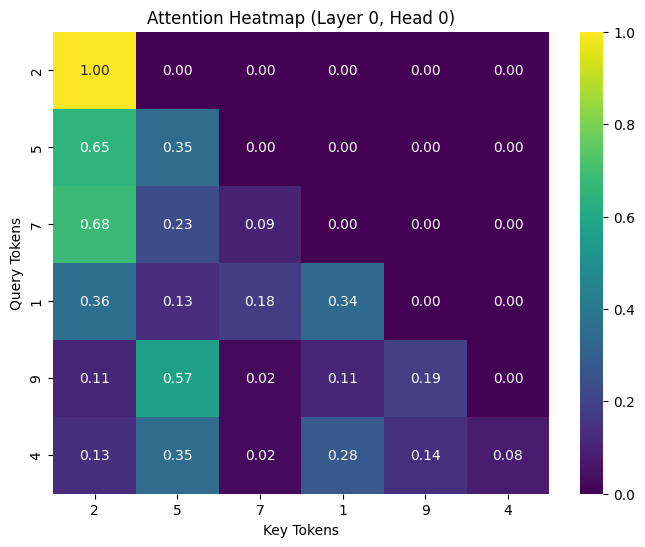

In [11]:
vocab_size = 50
max_seq_len = 16
d_model = 32
num_heads = 4
num_layers = 2
d_ff = 64

USE_ROPE = True
USE_WEIGHT_TYING = True
VISUALIZE = True

print("=== PENGUJIAN DENGAN FITUR BONUS ===")
print(f"Menggunakan RoPE: {USE_ROPE}")
print(f"Menggunakan Weight Tying: {USE_WEIGHT_TYING}")

pos_method = 'rope' if USE_ROPE else 'sinusoidal'
model = TransformerDecoder(
    vocab_size=vocab_size, max_seq_len=max_seq_len, d_model=d_model,
    num_heads=num_heads, num_layers=num_layers, d_ff=d_ff,
    pos_encoding_method=pos_method, use_weight_tying=USE_WEIGHT_TYING
)

tokens = np.array([
    [2, 5, 7, 1, 9, 4],
    [3, 8, 2, 6, 0, 0]
], dtype=int)

logits, probs, attn_maps = model.forward(tokens)

print("\n=== OUTPUTS ===")
print("logits shape:", logits.shape)
print("probs shape (next token):", probs.shape)
print("sum probs each batch (should ~1):", probs.sum(axis=-1))

attn0 = attn_maps[0]
print("\nAttention weights for layer 0, head 0 (batch 0):\n", attn0[0, 0])

seq = tokens.shape[1]
violations = np.sum(attn0[0, 0][np.triu_indices(seq, k=1)] > 1e-6)
print("\nMasking violations:", violations)
assert violations == 0
print("\nTest passed.")

# --- Panggil Fungsi Visualisasi ---
if VISUALIZE and attn_maps:
    print("\nVisualisasi atensi untuk Layer 0, Head 0")
    visualize_attention(attn_maps[0], tokens, layer=0, head=0)